# Experimental Design
***
## Lipid Bilayers

Import the necessary packages and code to generate the bilayer results.

In [1]:
%matplotlib inline

import numpy as np
import sys

# For copying the model when sampling.
from copy import deepcopy

# Code for optimising and visualising.
from hogben.optimise import Optimiser
from hogben.visualise import contrast_choice_single, contrast_choice_double, underlayer_choice

# Bilayer models.
from hogben.models.bilayers import BilayerDMPC, BilayerDPPC

# Reduce size of plots for the notebook.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['figure.dpi'] = 100

Select the bilayer model to generate results for: either the 1,2-dimyristoyl-sn-glycero-3-phosphocholine (DMPC) or the 1,2-dipalmitoyl-sn-glycero-3-phosphocholine (DPPC) / lipopolysaccharide (LPS) bilayer.

This cell will also get the fitted SLD profile and reflectivity curve for the experimentally-measured data sets of the chosen model.

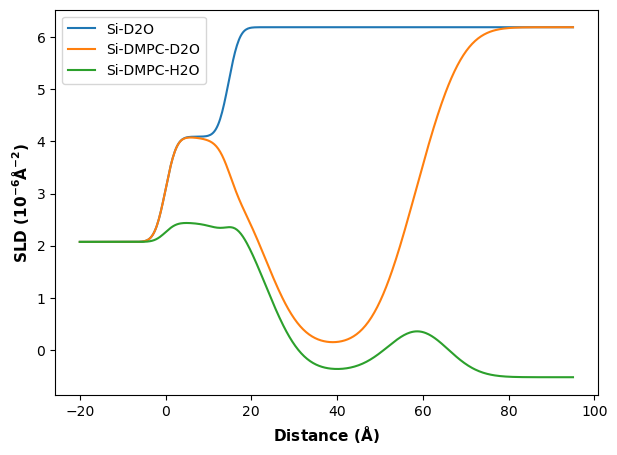

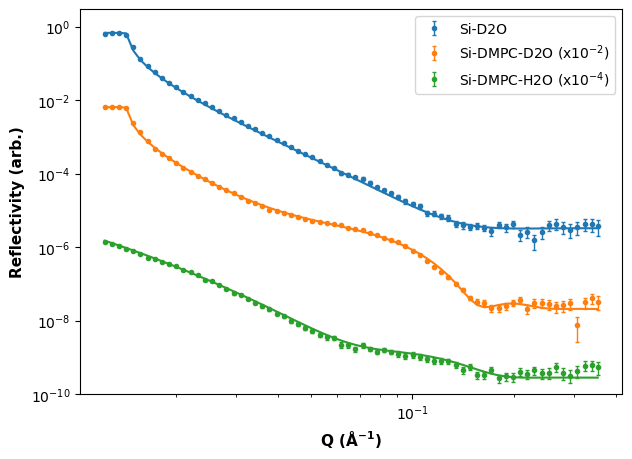

In [2]:
bilayer = BilayerDMPC() # Options are BilayerDMPC or BilayerDPPC.

save_path = './results'
bilayer.sld_profile(save_path)
bilayer.reflectivity_profile(save_path)

### Contrast Choice
***
Get the plot of minimum eigenvalue versus bulk water contrast SLD, for the chosen bilayer model, for the simultaneous choice of two contrasts assuming no prior measurement.

In [3]:
# Number of points and counting times for each angle to simulate.
angle_times = [(0.7, 100, 10),
               (2.3, 100, 40)]

# Change the number of points in the contrast range to increase/decrease detail of the plot.
contrast_range = np.linspace(-0.56, 6.36, 5)
contrast_choice_double(bilayer, contrast_range, angle_times, save_path)

# Adjust the viewing angle of the 3D plot.
ax = plt.gca()
ax.view_init(elev=40, azim=50)

>>> 0/10


AttributeError: 'BilayerDMPC' object has no attribute 'scale'

Get the nested sampling corner plots from sampling simulated data of solely D2O, and simulated data of D2O and H2O.

In [ ]:
bilayer_copy = deepcopy(bilayer)
bilayer_copy.nested_sampling([6.36, 6.36], angle_times, save_path, 'D2O_D2O')
bilayer_copy.nested_sampling([-0.56, 6.36], angle_times, save_path, 'H2O_D2O')

Get the plot of minimum eigenvalue versus bulk water contrast SLD for the chosen bilayer model, for a third contrast choice, assuming D2O and H2O have been previously measured. 

This plot may look slightly different to the one shown in the paper as here we assume D2O and H2O have been measured for equal times.

In [ ]:
contrast_range = np.linspace(-0.56, 6.36, 100)
contrast_choice_single(bilayer, contrast_range, [-0.56, 6.36], angle_times, save_path, 'H2O_D2O')

Using differential evolution, optimise the contrast SLDs and counting time splits, for the chosen bilayer model, using a given number of contrasts.

In [ ]:
# Number of contrasts to optimise.
num_contrasts = 2

# Range of contrasts to optimise over.
contrast_bounds = (-0.56, 6.36)

# Counting time splits between angles to simulate.
angle_splits = [(0.7, 100, 0.2),
                (2.3, 100, 0.8)]

optimiser = Optimiser(bilayer)
contrasts, splits, val = optimiser.optimise_contrasts(num_contrasts, angle_splits,
                                                      contrast_bounds=contrast_bounds, verbose=False)
# Convert to percentages.
splits = np.array(splits)*100

# Round the optimisation function value to 4 significant figures.
val = np.format_float_positional(val, precision=4, unique=False, fractional=False, trim='k')

print('Contrasts: {}'.format(list(np.round(contrasts, 2))))
print('Time Splits (%): {}'.format(list(np.round(splits, 1))))
print('Objective value: {}'.format(val))

### Angle Choice
***
Using differential evolution, optimise the angles and counting time splits, for the chosen bilayer model, using a given number angles.

In [ ]:
# Number of angles to optimise.
num_angles = 2

# Contrasts to use when simulating.
contrasts = [-0.56, 6.36]

# Range of angles to optimise over.
angle_bounds = (0.2, 4.0)

angles, splits, val = optimiser.optimise_angle_times(num_angles, contrasts,
                                                     angle_bounds=angle_bounds, verbose=False)
# Convert to percentages.
splits = np.array(splits)*100

# Round the optimisation function value to 4 significant figures.
val = np.format_float_positional(val, precision=4, unique=False, fractional=False, trim='k')

print('Angles: {}'.format(list(np.round(angles, 2))))
print('Time Splits (%): {}'.format(list(np.round(splits, 1))))
print('Objective value: {}'.format(val))

### Underlayer Choice
***
Get the plot of minimum eigenvalue versus underlayer SLD and underlayer thickness, for the chosen bilayer model, assuming D2O and H2O are being measured.

In [ ]:
# Contrasts to simulate.
contrasts = [-0.56, 6.36]

# Range of thicknesses and SLDs to visualise over.
# Change the number of points to increase/decrease detail of the plot.
thickness_range = np.linspace(5, 500, 25)
sld_range = np.linspace(1, 9, 5)

underlayer_choice(bilayer, thickness_range, sld_range, contrasts, angle_times, save_path, 'D2O_H2O')

# Adjust the viewing angle of the 3D plot.
ax = plt.gca()
ax.view_init(elev=40, azim=230)

Get the nested sampling corner plots from sampling simulated data of D2O and H2O without any underlayer and with a single underlayer.

In [ ]:
# No underlayer.
bilayer_copy.nested_sampling([-0.56, 6.36], [(0.7, 100, 40)], save_path, 'D2O_H2O_without_underlayer', underlayers=[]);

# Select the appropriate optimal underlayer.
if isinstance(bilayer, BilayerDMPC):
    underlayers = [(127.1, 5.39)] # Optimal DMPC bilayer underlayer.
elif isinstance(bilayer, BilayerDPPC):
    underlayers = [(76.5, 9.00)] # Optimal DPPC/Ra LPS bilayer underlayer.
else:
    raise RuntimeError('Invalid bilayer model')
    
bilayer_copy.nested_sampling([-0.56, 6.36], [(0.7, 100, 40)], save_path, 'D2O_H2O_with_underlayer', underlayers=underlayers);

Calculate the minimum eigenvalue without any underlayers.

In [ ]:
# Calculate the objective value using no underlayers.
fisher = bilayer.underlayer_info(angle_times, contrasts, [])
val = -fisher.min_eigenval
val = np.format_float_positional(val, precision=4, unique=False, fractional=False, trim='k')

print('------------ No Underlayer ------------')
print('Objective value: {}'.format(val))

Calculate the minimum eigenvalue using gold and Permalloy underlayers.

In [ ]:
# Calculate the objective value using gold underlayer.
underlayer = [(100, 4.7)]
fisher = bilayer.underlayer_info(angle_times, contrasts, [])
val = -fisher.min_eigenval
val = np.format_float_positional(val, precision=4, unique=False, fractional=False, trim='k')

print('------------ Au Underlayer ------------')
print('Thicknesses: {}'.format([underlayer[0][0]]))
print('SLDs: {}'.format([underlayer[0][1]]))
print('Objective value: {}\n'.format(val))

# Calculate the objective value using a Permalloy underlayer.
underlayer = [(100, 8.4)]
fisher = bilayer.underlayer_info(angle_times, contrasts, [])
val = -fisher.min_eigenval
val = np.format_float_positional(val, precision=4, unique=False, fractional=False, trim='k')

print('--------- Permalloy Underlayer --------')
print('Thicknesses: {}'.format([underlayer[0][0]]))
print('SLDs: {}'.format([underlayer[0][1]]))
print('Objective value: {}'.format(val))

Using differential evolution, optimise the underlayer SLDs and thicknesses, for the chosen bilayer model, using a given number of underlayers.

In [ ]:
# Number of underlayers to optimise.
num_underlayers = 2

# Range of thicknesses and SLDs to optimise over.
thick_bounds = (0, 500)
sld_bounds = (1, 9)

thicknesses, slds, val = optimiser.optimise_underlayers(num_underlayers, angle_times, contrasts,
                                                        thick_bounds, sld_bounds, verbose=False)

# Round the optimisation function value to 4 significant figures.
val = np.format_float_positional(val, precision=4, unique=False, fractional=False, trim='k')

print('------------ {} Underlayers ------------'.format(num_underlayers))
print('Thicknesses: {}'.format(list(np.round(thicknesses, 1))))
print('SLDs: {}'.format(list(np.round(slds, 2))))
print('Objective value: {}'.format(val))